In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from time import time
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC

from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix


In [399]:
df = pd.read_csv('Datasets/breastcancer/breast-cancer-diagnostic.shuf.lrn.csv')
df.head()

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,868682,B,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.02875,...,12.32,22.02,79.93,462.0,0.1190,0.1648,0.1399,0.08476,0.2676,0.06765
1,881972,M,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.10900,...,19.59,24.89,133.50,1189.0,0.1703,0.3934,0.5018,0.25430,0.3109,0.09061
2,901315,B,10.57,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.05941,...,10.85,22.82,76.51,351.9,0.1143,0.3619,0.6030,0.14650,0.2597,0.12000
3,9112367,B,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,...,14.35,34.23,91.29,632.9,0.1289,0.1063,0.1390,0.06005,0.2444,0.06788
4,8711202,M,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,...,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.3583,0.15150,0.2463,0.07738


In [341]:
num_samples, num_features = df.shape
num_features -= 2 # correct for class and id
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       285 non-null    int64  
 1   class                    285 non-null    object 
 2   radiusMean               285 non-null    float64
 3    textureMean             285 non-null    float64
 4    perimeterMean           285 non-null    float64
 5    areaMean                285 non-null    float64
 6    smoothnessMean          285 non-null    float64
 7    compactnessMean         285 non-null    float64
 8    concavityMean           285 non-null    float64
 9    concavePointsMean       285 non-null    float64
 10   symmetryMean            285 non-null    float64
 11   fractalDimensionMean    285 non-null    float64
 12   radiusStdErr            285 non-null    float64
 13   textureStdErr           285 non-null    float64
 14   perimeterStdErr         2

# Primer

The goal of the dataset is to be able to classify the type of cancer based on various input data (about the breasts).

## Classes:

M... malignant

B... benign

In [342]:
pd.isnull(df.any())

ID                         False
class                      False
radiusMean                 False
 textureMean               False
 perimeterMean             False
 areaMean                  False
 smoothnessMean            False
 compactnessMean           False
 concavityMean             False
 concavePointsMean         False
 symmetryMean              False
 fractalDimensionMean      False
 radiusStdErr              False
 textureStdErr             False
 perimeterStdErr           False
 areaStdErr                False
 smoothnessStdErr          False
 compactnessStdErr         False
 concavityStdErr           False
 concavePointsStdErr       False
 symmetryStdErr            False
 fractalDimensionStdErr    False
 radiusWorst               False
 textureWorst              False
 perimeterWorst            False
 areaWorst                 False
 smoothnessWorst           False
 compactnessWorst          False
 concavityWorst            False
 concavePointsWorst        False
 symmetryW

Conclusio: no missing values

In [343]:
df.describe()

,ID,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
count,2.850000e+02,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,3.024415e+07,13.857832,19.310000,90.076070,625.102105,0.095960,0.101917,0.084848,0.046362,0.180695,...,15.823884,25.665825,104.135123,823.488421,0.132186,0.249617,0.265468,0.112228,0.290091,0.083933
std,1.295562e+08,3.252277,4.277718,22.227367,310.526144,0.013481,0.048350,0.073680,0.034868,0.028748,...,4.361540,6.128468,29.847173,482.465945,0.022661,0.151791,0.201241,0.063620,0.067542,0.018766
min,8.670000e+03,7.729000,9.710000,47.920000,178.800000,0.052630,0.023440,0.000000,0.000000,0.106000,...,8.952000,12.020000,56.650000,240.100000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.711490e+05,11.570000,16.170000,74.200000,409.100000,0.086370,0.064920,0.030460,0.021680,0.161900,...,12.840000,21.190000,83.850000,505.600000,0.117200,0.146000,0.116800,0.063430,0.247700,0.072070
50%,9.055020e+05,13.150000,18.910000,84.450000,536.900000,0.095940,0.092180,0.059280,0.032640,0.177800,...,14.670000,25.440000,96.310000,657.000000,0.130300,0.211900,0.210200,0.099100,0.280400,0.079440
75%,8.711561e+06,15.490000,21.800000,102.500000,748.900000,0.104600,0.129600,0.120400,0.065760,0.195300,...,18.070000,30.360000,121.200000,989.500000,0.146100,0.341600,0.382900,0.156100,0.316800,0.091870
max,9.113205e+08,27.220000,33.810000,182.100000,2250.000000,0.142500,0.283900,0.410800,0.187800,0.304000,...,33.120000,45.410000,220.800000,3216.000000,0.222600,1.058000,1.105000,0.273300,0.663800,0.207500


In [268]:
def describe_cols(dataframe, n=3):
    for col in dataframe.columns:
        print("-"*40)
        print(f"Column: {col}")
        print(f"Top {n} vals")
        counts = dataframe[col].value_counts()
        print(counts.iloc[0:min(len(counts),3)])
        print("# of unique values: ", dataframe[col].nunique())

In [269]:
describe_cols(df)

----------------------------------------
Column: ID
Top 3 vals
91789       1
88147102    1
852631      1
Name: ID, dtype: int64
# of unique values:  285
----------------------------------------
Column: class
Top 3 vals
B    189
M     96
Name: class, dtype: int64
# of unique values:  2
----------------------------------------
Column: radiusMean
Top 3 vals
10.26    3
12.05    2
13.87    2
Name: radiusMean, dtype: int64
# of unique values:  253
----------------------------------------
Column:  textureMean
Top 3 vals
18.22    3
16.85    3
21.68    2
Name:  textureMean, dtype: int64
# of unique values:  261
----------------------------------------
Column:  perimeterMean
Top 3 vals
87.76     3
82.61     2
107.10    2
Name:  perimeterMean, dtype: int64
# of unique values:  274
----------------------------------------
Column:  areaMean
Top 3 vals
466.1    2
321.6    2
716.6    2
Name:  areaMean, dtype: int64
# of unique values:  277
----------------------------------------
Column:  smoothnessM

# Features

Information is presented on:

- radius
- texture
- perimeter
- area
- smoothness
- compactness
- concavity
- concavePoints
- symmetry
- fractalDimension

However, that information is split into 3 seperate categories/types per "base feature" (above):

- Mean
- Standard error/deviation (StdErr)
- Worst

While Mean and StdErr are self explanatory, we don't really understand what "Worst" means in this context...it doesn't really matter to us and in fact it might help us with staying unbiased when exploring the data further.

In [403]:
# Some column names have " " (spaces) in front of them --> strip them
cols = df.columns
new_cols = []
for ele in cols:
    new_cols.append(ele.strip(" "))
new_cols

['ID',
 'class',
 'radiusMean',
 'textureMean',
 'perimeterMean',
 'areaMean',
 'smoothnessMean',
 'compactnessMean',
 'concavityMean',
 'concavePointsMean',
 'symmetryMean',
 'fractalDimensionMean',
 'radiusStdErr',
 'textureStdErr',
 'perimeterStdErr',
 'areaStdErr',
 'smoothnessStdErr',
 'compactnessStdErr',
 'concavityStdErr',
 'concavePointsStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'radiusWorst',
 'textureWorst',
 'perimeterWorst',
 'areaWorst',
 'smoothnessWorst',
 'compactnessWorst',
 'concavityWorst',
 'concavePointsWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [405]:
df.columns = new_cols

In [346]:
ID = df.columns[0]
clas = df.columns[1]
feats = df.columns[2:]

In [292]:
#feats_mean = df.columns
feats_mean = [feat for feat in feats if 'Mean' in feat ]
feats_mean

['radiusMean',
 'textureMean',
 'perimeterMean',
 'areaMean',
 'smoothnessMean',
 'compactnessMean',
 'concavityMean',
 'concavePointsMean',
 'symmetryMean',
 'fractalDimensionMean']

In [293]:
feats_Std = [feat for feat in feats if 'Std' in feat ]
feats_Std

['radiusStdErr',
 'textureStdErr',
 'perimeterStdErr',
 'areaStdErr',
 'smoothnessStdErr',
 'compactnessStdErr',
 'concavityStdErr',
 'concavePointsStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr']

In [294]:
feats_Worst = [feat for feat in feats if 'Worst' in feat ]
feats_Worst

['radiusWorst',
 'textureWorst',
 'perimeterWorst',
 'areaWorst',
 'smoothnessWorst',
 'compactnessWorst',
 'concavityWorst',
 'concavePointsWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [295]:
dfM=df[df[clas] == 'M']
dfB=df[df[clas] == 'B']

In [296]:
count_classes = df[clas].value_counts()
count_classes

B    189
M     96
Name: class, dtype: int64

In [297]:
dist_classes = count_classes.apply(lambda x: x/num_samples)
dist_classes.index

Index(['B', 'M'], dtype='object')

# Visualize data

In [298]:
from math import log2

Text(0.2, 0.8, 'Entropy= 0.922')

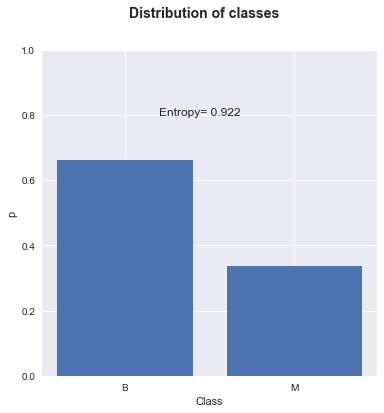

In [299]:

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(6,6))
plt.bar(dist_classes.index, dist_classes)
plt.suptitle("Distribution of classes", fontsize=14, weight="bold")
plt.ylim((0,1))
plt.ylabel("p")
plt.xlabel("Class")

entropy = -sum([p*log2(p) for p in dist_classes])
plt.annotate(f"Entropy= {entropy:.3f}", (0.2, 0.8))

(Luckily) benign cancer seems to be more prevalent than maligned.

For us, this means the dataset is skewed towards more class 'B' samples.
The overall entropy of the set is 0.922, where entropy=1 would be a perfectly evenly distributed set.

In [322]:
import matplotlib as mpl
def plot_hist_type(df, list_feats, feature_type, stacked=True):
    mpl.style.use('seaborn')
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,10))
    fig.suptitle(f"Features {feature_type}", x=0.5, y=1, fontsize=14, weight="bold")
    axes = axes.ravel()
    for index,ax in enumerate(axes):
        ax.figure
        binwidth= (max(df[list_feats[index]]) - min(df[list_feats[index]]))/50
        ax.hist([dfM[list_feats[index]],dfB[list_feats[index]]], bins=np.arange(min(df[list_feats[index]]), max(df[list_feats[index]]) + binwidth, binwidth), alpha=1, stacked=stacked, label=['M','B'], density=True) #, color=['xkcd:light yellow','b']
        ax.legend(loc='upper right')
        ax.set_title(list_feats[index])
    plt.tight_layout()
    plt.show()

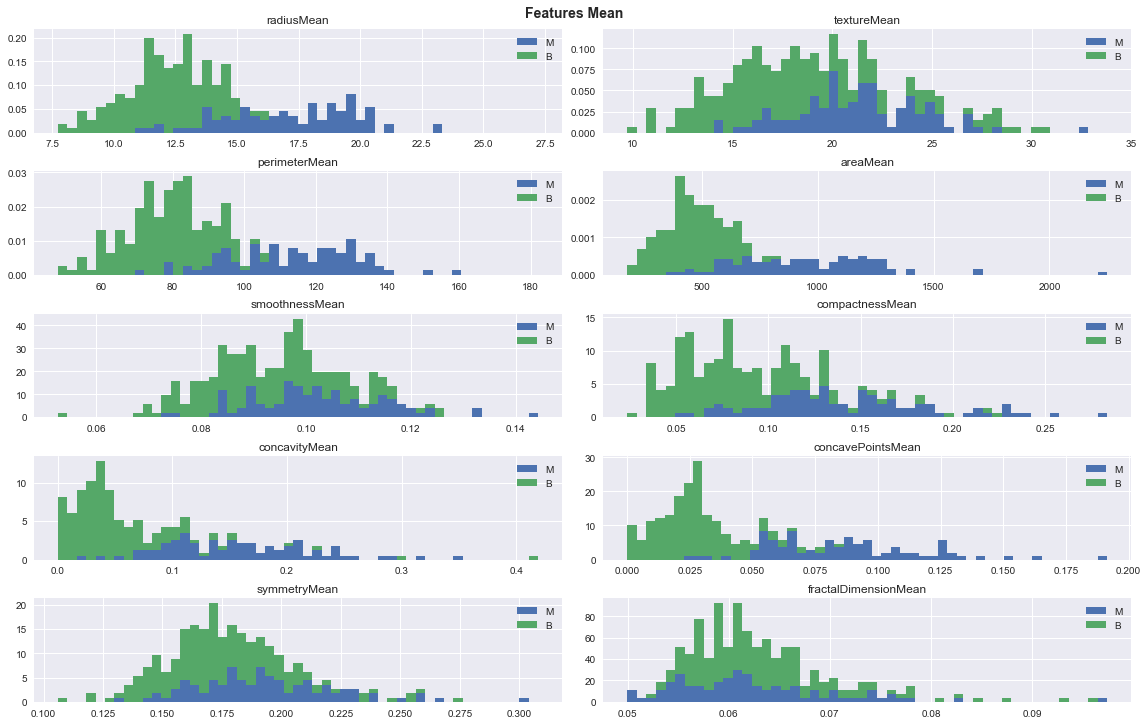

In [323]:
plot_hist_type(df, feats_mean, 'Mean')

# Conlusio Mean features

At first glance, there are several notable differences between the distributions for "M" and "B":

For all features but "symmetryMean", "fractalDimensionMean" and "smoothnessMean", the distributions skew towards higher values for "M" than for "B".

We will therefore consider dropping these 3, as they do not seem to be good indicators.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"]

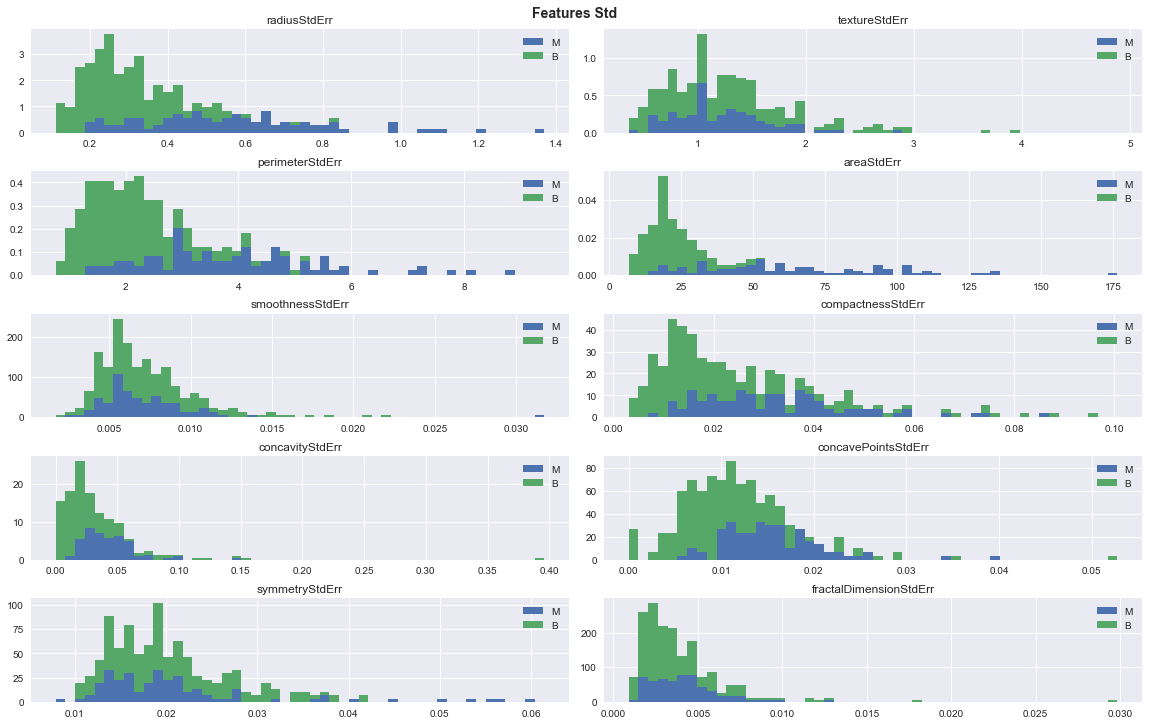

In [324]:
plot_hist_type(df, feats_Std, 'Std')

# Conclusio StdErr features

These featuers seem to overall not be too good indicators. Some do not seem to be bad indicators, these are considered for dropping again and are added to the list.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + \["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"]

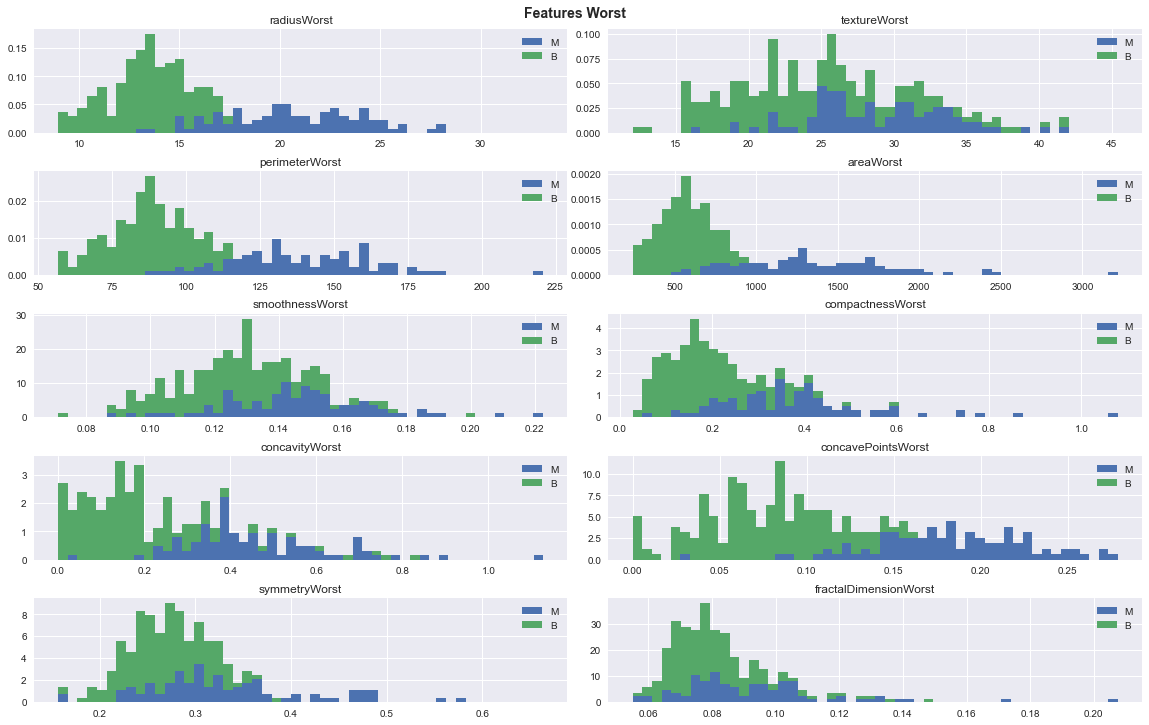

In [325]:
plot_hist_type(df, feats_Worst, 'Worst')

# Conclusio "Worst" features

Same procedure as above.

Consider to drop (so far):

\["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + \["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"] + \["textureWorst", "smoothnessWorst", "symmetryWorst", "fractalDimensionWorst"]

In [304]:
feats

Index(['radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'smoothnessMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
       'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
       'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
       'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
       'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
       'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst'],
      dtype='object')

In [305]:
# We have to add spaces at the start of all of them...
feats_to_drop = ["symmetryMean", "fractalDimensionMean", "smoothnessMean"] + ["textureStdErr", "smoothnessStdErr", "concavityStdErr", "symmetryStdErr", "fractalDimensionStdErr"] + ["textureWorst", "smoothnessWorst", "symmetryWorst", "fractalDimensionWorst"]
feats_to_drop

['symmetryMean',
 'fractalDimensionMean',
 'smoothnessMean',
 'textureStdErr',
 'smoothnessStdErr',
 'concavityStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'textureWorst',
 'smoothnessWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

In [306]:
df.columns = new_cols
df.columns

Index(['ID', 'class', 'radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'smoothnessMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
       'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
       'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
       'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
       'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
       'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst'],
      dtype='object')

In [307]:
feats

Index(['radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'smoothnessMean', 'compactnessMean', 'concavityMean',
       'concavePointsMean', 'symmetryMean', 'fractalDimensionMean',
       'radiusStdErr', 'textureStdErr', 'perimeterStdErr', 'areaStdErr',
       'smoothnessStdErr', 'compactnessStdErr', 'concavityStdErr',
       'concavePointsStdErr', 'symmetryStdErr', 'fractalDimensionStdErr',
       'radiusWorst', 'textureWorst', 'perimeterWorst', 'areaWorst',
       'smoothnessWorst', 'compactnessWorst', 'concavityWorst',
       'concavePointsWorst', 'symmetryWorst', 'fractalDimensionWorst'],
      dtype='object')

In [308]:
feats_stripped = feats.drop(feats_to_drop)
feats_stripped

Index(['radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'compactnessMean', 'concavityMean', 'concavePointsMean', 'radiusStdErr',
       'perimeterStdErr', 'areaStdErr', 'compactnessStdErr',
       'concavePointsStdErr', 'radiusWorst', 'perimeterWorst', 'areaWorst',
       'compactnessWorst', 'concavityWorst', 'concavePointsWorst'],
      dtype='object')

In [434]:
def encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = original_dataframe.copy()
    res[feature_to_encode] = dummies
    return(res)

def decode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = original_dataframe.copy()
    res[feature_to_encode] = dummies
    return(res)

In [371]:
df_changed = encode(df, clas)
df_changed

# B...1
# M...0

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,868682,1,11.43,15.39,73.06,399.8,0.09639,0.06889,0.03503,0.028750,...,12.32,22.02,79.93,462.0,0.1190,0.16480,0.13990,0.08476,0.2676,0.06765
1,881972,0,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.109000,...,19.59,24.89,133.50,1189.0,0.1703,0.39340,0.50180,0.25430,0.3109,0.09061
2,901315,1,10.57,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.059410,...,10.85,22.82,76.51,351.9,0.1143,0.36190,0.60300,0.14650,0.2597,0.12000
3,9112367,1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.020680,...,14.35,34.23,91.29,632.9,0.1289,0.10630,0.13900,0.06005,0.2444,0.06788
4,8711202,0,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.105400,...,20.47,25.11,132.90,1302.0,0.1418,0.34980,0.35830,0.15150,0.2463,0.07738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,0,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.074150,...,13.74,26.38,91.93,591.7,0.1385,0.40920,0.45040,0.18650,0.5774,0.10300
281,871149,1,10.90,12.96,68.69,366.8,0.07515,0.03718,0.00309,0.006588,...,12.36,18.20,78.07,470.0,0.1171,0.08294,0.01854,0.03953,0.2738,0.07685
282,84667401,0,13.73,22.61,93.60,578.3,0.11310,0.22930,0.21280,0.080250,...,15.03,32.01,108.80,697.7,0.1651,0.77250,0.69430,0.22080,0.3596,0.14310
283,912558,1,13.70,17.64,87.76,571.1,0.09950,0.07957,0.04548,0.031600,...,14.96,23.53,95.78,686.5,0.1199,0.13460,0.17420,0.09077,0.2518,0.06960


In [384]:
def plot_corr_heatmap(df, fmt=".2f"):
    plt.rcParams.update({'font.size': 12})
    # Compute correlations and save in matrix
    corr = np.abs(df.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
    # Mask the repeated values --> here: upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True # mask upper triangle

    corr_to_class = corr[:,0]
    
    f, ax = plt.subplots(figsize=(18, 16))
    sns.heatmap(corr, annot=True, fmt=fmt , mask=mask, vmin=0, vmax=1, linewidths=.5)
    plt.show()
    return corr_to_class

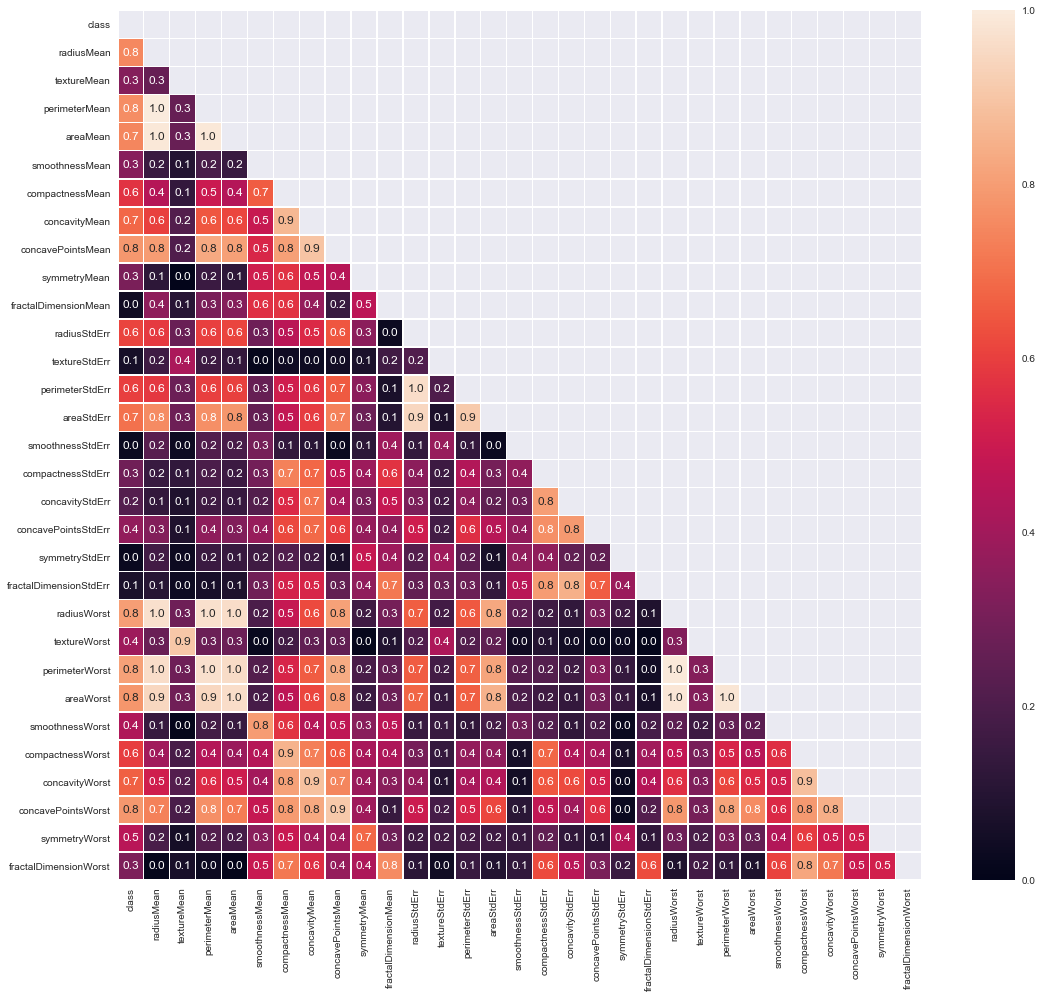

In [388]:
corr_to_class = plot_corr_heatmap(df_changed.drop("ID", axis=1), fmt=".1f")

In [390]:
# We are thinking about droping:
feats_to_drop

['symmetryMean',
 'fractalDimensionMean',
 'smoothnessMean',
 'textureStdErr',
 'smoothnessStdErr',
 'concavityStdErr',
 'symmetryStdErr',
 'fractalDimensionStdErr',
 'textureWorst',
 'smoothnessWorst',
 'symmetryWorst',
 'fractalDimensionWorst']

# Conclusio of Correlation Heatmap

If we compare our results from the histograms with the correlation plot, we notice that although most features we selected for dropping seem to be a good choice (for dropping), there are some that seem to correlate surprisingly well with the class!

1) Specifically, the "Mean" and "StdErr" features to be dropped, do NOT correlate well with the class (according to the heatmap above). This agrees with our findings from before.

2) The "Worst" features correlate higher with the class than we expected (based on the histograms). The ones we selected for dropping also have lower correlation scores than the others, but they aren't as bad as the "Mean" and "StdErr" values, that we selected for dropping.


## Decision

We will drop all proposed features for now and check the performance.

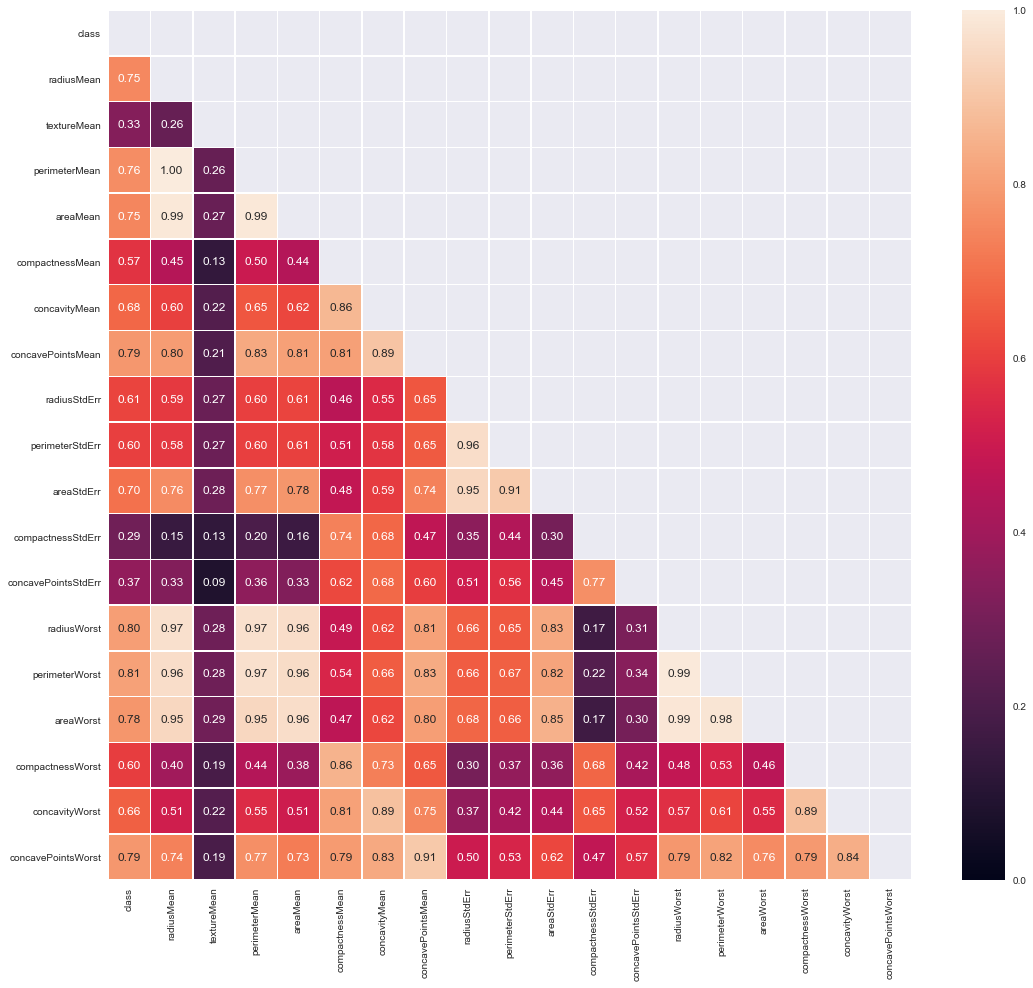

In [398]:
# Heatmap of reduced df

corr_to_class_stripped = plot_corr_heatmap(df_changed.drop(feats_to_drop+["ID"], axis=1))

In [406]:
# The df we will use for the rest:
df = df.drop(feats_to_drop, axis=1)
df

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,perimeterStdErr,areaStdErr,compactnessStdErr,concavePointsStdErr,radiusWorst,perimeterWorst,areaWorst,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,B,11.43,15.39,73.06,399.8,0.06889,0.03503,0.028750,0.1759,1.143,12.670,0.015210,0.008602,12.32,79.93,462.0,0.16480,0.13990,0.08476
1,881972,M,17.05,19.08,113.40,895.0,0.15720,0.19100,0.109000,0.2959,2.153,31.980,0.020080,0.013840,19.59,133.50,1189.0,0.39340,0.50180,0.25430
2,901315,B,10.57,20.22,70.15,338.3,0.16600,0.22800,0.059410,0.1115,2.363,7.228,0.076430,0.029190,10.85,76.51,351.9,0.36190,0.60300,0.14650
3,9112367,B,13.21,25.25,84.10,537.9,0.05205,0.02772,0.020680,0.2084,1.314,17.580,0.008082,0.006451,14.35,91.29,632.9,0.10630,0.13900,0.06005
4,8711202,M,17.68,20.74,117.40,963.7,0.16650,0.18550,0.105400,0.8113,5.540,93.910,0.049540,0.018410,20.47,132.90,1302.0,0.34980,0.35830,0.15150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,M,11.80,16.58,78.99,432.0,0.17000,0.16590,0.074150,0.3197,2.281,24.720,0.036330,0.018430,13.74,91.93,591.7,0.40920,0.45040,0.18650
281,871149,B,10.90,12.96,68.69,366.8,0.03718,0.00309,0.006588,0.2818,1.808,18.540,0.006134,0.003576,12.36,78.07,470.0,0.08294,0.01854,0.03953
282,84667401,M,13.73,22.61,93.60,578.3,0.22930,0.21280,0.080250,0.2121,2.061,19.210,0.059360,0.016280,15.03,108.80,697.7,0.77250,0.69430,0.22080
283,912558,B,13.70,17.64,87.76,571.1,0.07957,0.04548,0.031600,0.2431,1.564,20.640,0.008186,0.009233,14.96,95.78,686.5,0.13460,0.17420,0.09077


In [407]:
feats = df.columns[2:]
feats

Index(['radiusMean', 'textureMean', 'perimeterMean', 'areaMean',
       'compactnessMean', 'concavityMean', 'concavePointsMean', 'radiusStdErr',
       'perimeterStdErr', 'areaStdErr', 'compactnessStdErr',
       'concavePointsStdErr', 'radiusWorst', 'perimeterWorst', 'areaWorst',
       'compactnessWorst', 'concavityWorst', 'concavePointsWorst'],
      dtype='object')

# Scale features

Scaler: StandardScaler

Some Classifiers need scaled features/ work much better, for others (e.g. randomForst) it shouldn't make a difference either way.

In [436]:
scaled_features = StandardScaler().fit_transform(df[feats].values)
df[feats] = scaled_features
df_MB = df.copy()
df_MB

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,perimeterStdErr,areaStdErr,compactnessStdErr,concavePointsStdErr,radiusWorst,perimeterWorst,areaWorst,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,B,-0.747815,-0.917988,-0.766893,-0.726826,-0.684283,-0.677338,-0.505998,-0.981918,-1.068346,-0.815413,-0.606683,-0.541445,-0.804773,-0.812395,-0.750570,-0.559757,-0.625066,-0.432503
1,881972,M,0.983244,-0.053862,1.051180,0.870692,1.145409,1.443253,1.799579,-0.408980,-0.370335,-0.128211,-0.326410,0.266467,0.865002,0.985572,0.758923,0.948905,1.176435,2.237070
2,901315,B,-1.012710,0.213104,-0.898043,-0.925225,1.327736,1.946310,0.374862,-1.289394,-0.225204,-1.009082,2.916579,2.634060,-1.142402,-0.927180,-0.979174,0.741019,1.680198,0.539653
3,9112367,B,-0.199544,1.391033,-0.269334,-0.281314,-1.033190,-0.776726,-0.737848,-0.826747,-0.950168,-0.640677,-1.016905,-0.873216,-0.338522,-0.431120,-0.395725,-0.945832,-0.629546,-0.821587
4,8711202,M,1.177296,0.334878,1.231455,1.092319,1.338095,1.368474,1.696152,2.051787,1.970422,2.075746,1.369037,0.971346,1.067120,0.965434,0.993548,0.661164,0.462107,0.618383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,M,-0.633849,-0.639313,-0.499635,-0.622948,1.410611,1.101989,0.798341,-0.295348,-0.281874,-0.386579,0.608791,0.974431,-0.478627,-0.409640,-0.481269,1.053179,0.920571,1.169492
281,871149,B,-0.911064,-1.487047,-0.963843,-0.833284,-1.341281,-1.111599,-1.142711,-0.476300,-0.608764,-0.606512,-1.129014,-1.316658,-0.795585,-0.874822,-0.733959,-1.099998,-1.229183,-1.144694
282,84667401,M,-0.039374,0.772796,0.158819,-0.150984,2.639246,1.739649,0.973594,-0.809082,-0.433916,-0.582669,1.934187,0.642814,-0.182339,0.156567,-0.261178,3.450804,2.134680,1.709579
283,912558,B,-0.048615,-0.391082,-0.104382,-0.174211,-0.463004,-0.535258,-0.424118,-0.661073,-0.777393,-0.531778,-1.010920,-0.444119,-0.198417,-0.280423,-0.284433,-0.759064,-0.454324,-0.337870


In [437]:
df = encode(df, clas)
df

,ID,class,radiusMean,textureMean,perimeterMean,areaMean,compactnessMean,concavityMean,concavePointsMean,radiusStdErr,perimeterStdErr,areaStdErr,compactnessStdErr,concavePointsStdErr,radiusWorst,perimeterWorst,areaWorst,compactnessWorst,concavityWorst,concavePointsWorst
0,868682,1,-0.747815,-0.917988,-0.766893,-0.726826,-0.684283,-0.677338,-0.505998,-0.981918,-1.068346,-0.815413,-0.606683,-0.541445,-0.804773,-0.812395,-0.750570,-0.559757,-0.625066,-0.432503
1,881972,0,0.983244,-0.053862,1.051180,0.870692,1.145409,1.443253,1.799579,-0.408980,-0.370335,-0.128211,-0.326410,0.266467,0.865002,0.985572,0.758923,0.948905,1.176435,2.237070
2,901315,1,-1.012710,0.213104,-0.898043,-0.925225,1.327736,1.946310,0.374862,-1.289394,-0.225204,-1.009082,2.916579,2.634060,-1.142402,-0.927180,-0.979174,0.741019,1.680198,0.539653
3,9112367,1,-0.199544,1.391033,-0.269334,-0.281314,-1.033190,-0.776726,-0.737848,-0.826747,-0.950168,-0.640677,-1.016905,-0.873216,-0.338522,-0.431120,-0.395725,-0.945832,-0.629546,-0.821587
4,8711202,0,1.177296,0.334878,1.231455,1.092319,1.338095,1.368474,1.696152,2.051787,1.970422,2.075746,1.369037,0.971346,1.067120,0.965434,0.993548,0.661164,0.462107,0.618383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,869691,0,-0.633849,-0.639313,-0.499635,-0.622948,1.410611,1.101989,0.798341,-0.295348,-0.281874,-0.386579,0.608791,0.974431,-0.478627,-0.409640,-0.481269,1.053179,0.920571,1.169492
281,871149,1,-0.911064,-1.487047,-0.963843,-0.833284,-1.341281,-1.111599,-1.142711,-0.476300,-0.608764,-0.606512,-1.129014,-1.316658,-0.795585,-0.874822,-0.733959,-1.099998,-1.229183,-1.144694
282,84667401,0,-0.039374,0.772796,0.158819,-0.150984,2.639246,1.739649,0.973594,-0.809082,-0.433916,-0.582669,1.934187,0.642814,-0.182339,0.156567,-0.261178,3.450804,2.134680,1.709579
283,912558,1,-0.048615,-0.391082,-0.104382,-0.174211,-0.463004,-0.535258,-0.424118,-0.661073,-0.777393,-0.531778,-1.010920,-0.444119,-0.198417,-0.280423,-0.284433,-0.759064,-0.454324,-0.337870


# Define metrics

The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :

    true positive (TP) : Malignant tumour correctly identified as malignant
    true negative (TN) : Benign tumour correctly identified as benign
    false positive (FP) : Benign tumour incorrectly identified as malignant
    false negative (FN) : Malignant tumour incorrectly identified as benign

Metrics :

    Accuracy : (TP +TN) / (TP + TN + FP +FN)
    Precision : TP / (TP + FP)
    Recall : TP / (TP + FN)


In [453]:
import itertools

# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))


# Precision-recall curve

In [ ]:
# Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();



# ROC curve

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


In [392]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();



# Learning curve

The Learning curve determines cross-validated training and test scores.


In [ ]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

# Cross validation metrics

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.


In [443]:
from sklearn.model_selection import cross_val_score

metrics_explanation = {
"TP": "true positive (TP) : Malignant tumour correctly identified as malignant",
"TN": "true negative (TN) : Benign tumour correctly identified as benign",
"FP": "false positive (FP) : Benign tumour incorrectly identified as malignant",
"FN": "false negative (FN) : Malignant tumour incorrectly identified as benign",
"Accuracy" : "Accuracy: (TP +TN) / (TP + TN + FP +FN)",
"Precision" : "Precision: TP / (TP + FP)",
"Recall" : "Recall: TP / (TP + FN)"
}

# Cross val metric
def cross_val_metrics(model, X, y) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print(f"[{sc}] : {scores.mean():0.5f} (+/- {scores.std():0.5f})")
    print("")
    for key in metrics_explanation:
        print(metrics_explanation[key])

# Train-Test(Validation)-Splitting

In [438]:
train, valid = train_test_split(df, test_size=.3) # We don't have that many samples
X_train = train[feats]
Y_train = train[clas]
X_valid = valid[feats]
Y_valid = valid[clas]
print("# of unique values in Y_train: ", Y_train.nunique())
print("# of unique values in Y_valid: ", Y_valid.nunique())

# of unique values in Y_train:  2
# of unique values in Y_valid:  2


# Random Forest

Note: scaled features should not make (much of) a difference.

In [449]:
n_estimators = 400
max_features = "auto"
if isinstance(max_features, int):
    print("num features per tree: ", max_features*num_features)
# max_depth = 10
# min_samples_leaf = 1
# min_samples_split = 2
criterion = "entropy" #"gini"

# Let's check out a default first
rf = RFC(n_jobs=-1, criterion=criterion , bootstrap=True, oob_score=True, n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,verbose=0,)
start = time()
rf.fit(X_train, Y_train)
traintime = time() - start
print("oob score:", rf.oob_score_)
print("max depth:", max([estimator.get_depth() for estimator in rf.estimators_]))
Y_pred = rf.predict(X_valid)
score = accuracy_score(Y_valid, Y_pred)
cm_rf = confusion_matrix(Y_valid, Y_pred)
print("Test on validation set:")
print(f"number of validation samples: {X_valid.shape[0]}")
print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)} correct")
print(f"traintime: {traintime}s")

oob score: 0.9748743718592965
max depth: 8
Test on validation set:
number of validation samples: 86
accuracy: 97.67% --> 84 correct
traintime: 1.0202128887176514s


In [450]:
# On validation set
cross_val_metrics(rf, X_valid, Y_valid)

[accuracy] : 0.93072 (+/- 0.06775)
[precision] : 0.93287 (+/- 0.08270)
[recall] : 0.96000 (+/- 0.04899)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)


In [451]:
# On train set
cross_val_metrics(rf, X_train, Y_train)

[accuracy] : 0.96474 (+/- 0.02020)
[precision] : 0.97931 (+/- 0.02759)
[recall] : 0.97090 (+/- 0.03565)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)


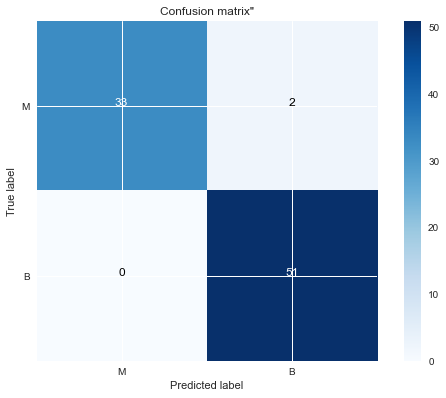

In [461]:
# On train set
print("train set")
cross_val_metrics(rf, X_train, Y_train)
# On validation set
print("validation set")
cross_val_metrics(rf, X_valid, Y_valid)
# B...1 --> 66%
# M...0 --> 33%
plot_confusion_matrix(cm_rf, ["M", "B"],
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues)

# Note on accuracy

The training data as a whole is split roughly:

B...benign:     66%

M..malignant:   33%

So, if we were to always predict benign, we would already be correct 66% percent of the time! (on the training set)

In [462]:
dist_classes

B    0.663158
M    0.336842
Name: class, dtype: float64

In [463]:
num_features = len(feats)
num_features

18

In [466]:
oob_scores = [0]
valid_scores = [0]
best_params = None
for max_feats in range(1,num_features+1):
    print(max_feats)
    rf_tmp = RFC(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=100, max_features=max_feats)#, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,verbose=0)
    start = time()
    rf_tmp.fit(X_train, Y_train)
    traintime = time() - start
    print("oob score:", rf_tmp.oob_score_)
    print("max depth:", max([estimator.get_depth() for estimator in rf_tmp.estimators_]))
    Y_pred = rf_tmp.predict(X_valid)
    score = accuracy_score(Y_valid, Y_pred)
    print(f"number of validation samples: {X_valid.shape[0]}")
    print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")
    print(f"traintime: {traintime}s")
    print("-"*30)
    if score >= max(valid_scores):
        if rf_tmp.oob_score_ > max(oob_scores):
            best_params = rf_tmp.get_params()
    oob_scores.append(rf_tmp.oob_score_)
    valid_scores.append(score)
oob_scores.pop(0)
valid_scores.pop(0)

1
oob score: 0.9447236180904522
max depth: 9
number of validation samples: 86
accuracy: 95.35% --> 82
traintime: 0.2858598232269287s
------------------------------
2
oob score: 0.964824120603015
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.2818489074707031s
------------------------------
3
oob score: 0.9698492462311558
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.2808399200439453s
------------------------------
4
oob score: 0.964824120603015
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.2782411575317383s
------------------------------
5
oob score: 0.9748743718592965
max depth: 7
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.28383874893188477s
------------------------------
6
oob score: 0.9547738693467337
max depth: 6
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.2909541130065918s
------------------------------
7
oob score: 0.96

0

In [471]:
oob_scores = [0]
valid_scores = [0]
best_params = None
for n_ests in range(100,1000+1,100):
    print(n_ests)
    rf = RFC(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=n_ests, max_features="auto")#, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,verbose=0)
    start = time()
    rf.fit(X_train, Y_train)
    traintime = time() - start
    print("oob score:", rf.oob_score_)
    print("max depth:", max([estimator.get_depth() for estimator in rf.estimators_]))
    Y_pred = rf.predict(X_valid)
    score = accuracy_score(Y_valid, Y_pred)
    print(f"number of validation samples: {X_valid.shape[0]}")
    print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")
    print(f"traintime: {traintime}s")
    print("-"*30)
    if score >= max(valid_scores):
        if rf.oob_score_ > max(oob_scores):
            best_params = rf.get_params()
    oob_scores.append(rf.oob_score_)
    valid_scores.append(score)
oob_scores.pop(0)
valid_scores.pop(0)

100
oob score: 0.9798994974874372
max depth: 8
number of validation samples: 86
accuracy: 96.51% --> 83
traintime: 0.2848365306854248s
------------------------------
200
oob score: 0.964824120603015
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.4677424430847168s
------------------------------
300
oob score: 0.9698492462311558
max depth: 7
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.6513969898223877s
------------------------------
400
oob score: 0.964824120603015
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 0.9120545387268066s
------------------------------
500
oob score: 0.9698492462311558
max depth: 8
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 1.4677724838256836s
------------------------------
600
oob score: 0.9698492462311558
max depth: 9
number of validation samples: 86
accuracy: 97.67% --> 84
traintime: 2.1261205673217773s
------------------------------
700
oo

0

In [472]:
print("oob_scores:")
print(oob_scores)
print("valid_scores:")
print(valid_scores)
print("")

print(f"best_score: (oob: {max(oob_scores)}, valid: {max(valid_scores)}")
print("best_params:")
best_params

oob_scores:
[0.9798994974874372, 0.964824120603015, 0.9698492462311558, 0.964824120603015, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558]
valid_scores:
[0.9651162790697675, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116]

best_score: (oob: 0.9798994974874372, valid: 0.9767441860465116
best_params:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [468]:
print("oob_scores:")
print(oob_scores)
print("valid_scores:")
print(valid_scores)
print("")

print(f"best_score: (oob: {max(oob_scores)}, valid: {max(valid_scores)}")
print("best_params:")
best_params

oob_scores:
[0.9447236180904522, 0.964824120603015, 0.9698492462311558, 0.964824120603015, 0.9748743718592965, 0.9547738693467337, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9748743718592965, 0.964824120603015, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9698492462311558, 0.9748743718592965, 0.9698492462311558, 0.9798994974874372]
valid_scores:
[0.9534883720930233, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9651162790697675, 0.9767441860465116, 0.9651162790697675, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9767441860465116, 0.9651162790697675, 0.9767441860465116]

best_score: (oob: 0.9798994974874372, valid: 0.9767441860465116
best_params:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 18,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# On train set
print("train set")
cross_val_metrics(rf, X_train, Y_train)
# On validation set
print("validation set")
cross_val_metrics(rf, X_valid, Y_valid)
# B...1 --> 66%
# M...0 --> 33%
plot_confusion_matrix(cm_rf, ["M", "B"],
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues)

# Multi-Layer-Perceptron

In [473]:
from sklearn.neural_network import MLPClassifier

In [474]:
clf = MLPClassifier(max_iter=500)
#clf = MLPClassifier(hidden_layer_sizes=(500,500,500), max_iter=300, alpha=i,solver='sgd', verbose=10,  random_state=21,tol=0.000000001,activation=j)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_valid)
print(accuracy_score(Y_valid, Y_pred))

0.9534883720930233


In [482]:
def MLP_Search(alphas,modes,solv, h):
    erg = []
    for g in h:
        for i in alphas:
            for j in modes:
                for k in solv:
                    clf = MLPClassifier(hidden_layer_sizes=g, max_iter=500, alpha=i,solver=k,activation=j)
                    clf.fit(X_train, Y_train)
                    Y_pred = clf.predict(X_valid)
                    print("Hidden layers: ",g,"|\talpha: ",i,"|\tmode: ",j,"|\tsolver: ",k,"|\tscore: ",accuracy_score(Y_valid, Y_pred))
                    erg.append({
                        "h": g,
                        "alpha": i,
                        "mode": j,
                        "solver": k,
                        "score": accuracy_score(Y_valid, Y_pred)})
        print("")
    return erg

In [483]:
alphas = [1e-5,1e-4,1e-3,1e-2,1e-1,0,1,10,100]
modes = ["identity","logistic","tanh","relu"]
solv = ["adam","sgd","lbfgs"]
h = [11,50,100,200,300,400]

# alphas = [1e-5,1e-4,1e-3,1]
# modes = ["relu"]
# solv = ["adam"]
results = MLP_Search(alphas, modes, solv, h)

83720930233
Hidden layers:  300 |	alpha:  1e-05 |	mode:  tanh |	solver:  adam |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  1e-05 |	mode:  tanh |	solver:  sgd |	score:  0.9883720930232558
Hidden layers:  300 |	alpha:  1e-05 |	mode:  tanh |	solver:  lbfgs |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  1e-05 |	mode:  relu |	solver:  adam |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  1e-05 |	mode:  relu |	solver:  sgd |	score:  0.9534883720930233
Hidden layers:  300 |	alpha:  1e-05 |	mode:  relu |	solver:  lbfgs |	score:  0.9534883720930233
Hidden layers:  300 |	alpha:  0.0001 |	mode:  identity |	solver:  adam |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  0.0001 |	mode:  identity |	solver:  sgd |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  0.0001 |	mode:  identity |	solver:  lbfgs |	score:  0.9651162790697675
Hidden layers:  300 |	alpha:  0.0001 |	mode:  logistic |	solver:  adam |	score:  0.9534883720930233
Hidden layers:  30

In [488]:
best_score = 0
best_index = 0
for i, res in enumerate(results):
    if res["score"] > best_score:
        best_score = res["score"]
        best_index = i
print("best_score:", best_score)
print("best_params:", results[best_index])
best_params = results[best_index]

best_score: 0.9883720930232558
best_params: {'h': [11, 50, 100, 200, 300, 400], 'alpha': 1e-05, 'mode': 'relu', 'solver': 'sgd', 'score': 0.9883720930232558}


In [527]:
layers = 75 # 75
mlp = MLPClassifier(hidden_layer_sizes=layers, max_iter=500, alpha=best_params["alpha"],solver=best_params["solver"],activation=best_params["mode"])
mlp.fit(X_train, Y_train)
Y_pred = mlp.predict(X_valid)
cm_mlp = confusion_matrix(Y_valid, Y_pred)
cm_mlp

array([[33,  2],
       [ 1, 50]], dtype=int64)

In [528]:
# On train set
print("train set")
cross_val_metrics(mlp, X_train, Y_train)
# On validation set
print("-"*30)
print("validation set")
cross_val_metrics(mlp, X_valid, Y_valid)
# B...1 --> 66%
# M...0 --> 33%


train set
[accuracy] : 0.94974 (+/- 0.02237)
[precision] : 0.95931 (+/- 0.03916)
[recall] : 0.96376 (+/- 0.03255)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
------------------------------
validation set
[accuracy] : 0.95359 (+/- 0.04386)
[precision] : 0.96333 (+/- 0.04522)
[recall] : 0.94000 (+/- 0.08000)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (T

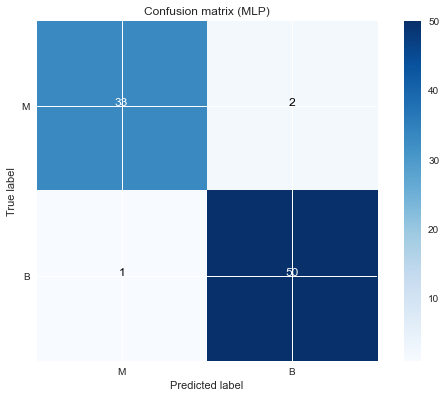

In [529]:
plot_confusion_matrix(cm_mlp, ["M", "B"],
                          normalize = False,
                          title = 'Confusion matrix (MLP)',
                          cmap = plt.cm.Blues)

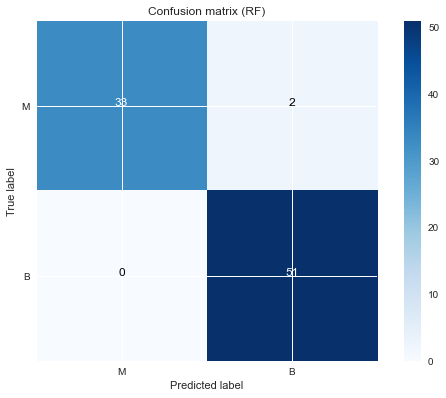

In [493]:
plot_confusion_matrix(cm_rf, ["M", "B"],
                          normalize = False,
                          title = 'Confusion matrix (RF)',
                          cmap = plt.cm.Blues)

# kNN

Note: Should use scaled features here

Expectation: should work well for this task!
After all, this technique has been widely used for CT-scans for years.

In [565]:
# KNN Test
from sklearn.neighbors import KNeighborsClassifier

scores = []
best_score = 0
best_ks = []
ks = list(range(1, 10)) + list(range(10, 20, 2)) + list(range(20, 51, 4))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_valid)
    score = accuracy_score(Y_valid, Y_pred)
    scores.append(score)
    best_score = max(scores)
    if score == best_score:
        best_ks.append(k)
    score
best_score
best_ks.pop(0)
best_ks.pop(0)
best_ks

[3, 5, 6, 7, 9, 10, 12, 14]

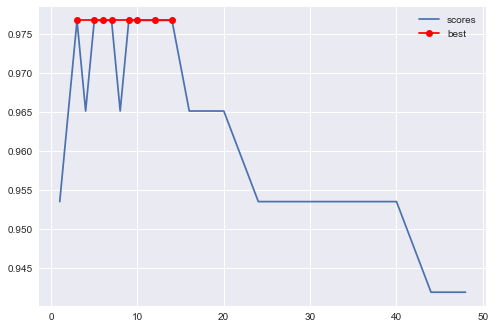

In [566]:
plt.plot(ks, scores, label="scores")
plt.plot(best_ks, [best_score]*len(best_ks), marker="o", color="red",label="best")
plt.legend()

In [588]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_valid)
score_knn = accuracy_score(Y_valid, Y_pred)
cm_knn = confusion_matrix(Y_valid, Y_pred)
cm_knn

array([[33,  2],
       [ 0, 51]], dtype=int64)

In [589]:
# On train set
print("train set")
cross_val_metrics(knn, X_train, Y_train)
# On validation set
print("-"*30)
print("validation set")
cross_val_metrics(knn, X_valid, Y_valid)
# B...1 --> 66%
# M...0 --> 33%


train set
[accuracy] : 0.95962 (+/- 0.02603)
[precision] : 0.95169 (+/- 0.02765)
[recall] : 0.99259 (+/- 0.01481)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
------------------------------
validation set
[accuracy] : 0.94183 (+/- 0.05263)
[precision] : 0.93000 (+/- 0.06360)
[recall] : 0.98000 (+/- 0.04000)

true positive (TP) : Malignant tumour correctly identified as malignant
true negative (TN) : Benign tumour correctly identified as benign
false positive (FP) : Benign tumour incorrectly identified as malignant
false negative (FN) : Malignant tumour incorrectly identified as benign
Accuracy: (TP +TN) / (TP + TN + FP +FN)
Precision: TP / (TP + FP)
Recall: TP / (T

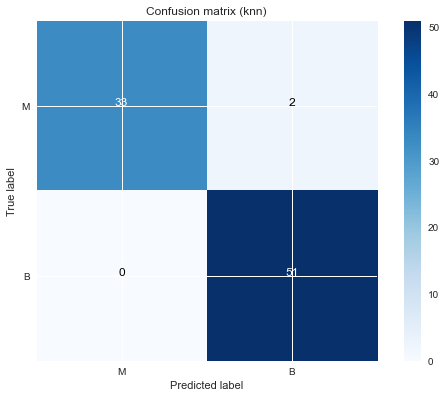

In [590]:
plot_confusion_matrix(cm_knn, ["M", "B"],
                          normalize = False,
                          title = 'Confusion matrix (knn)',
                          cmap = plt.cm.Blues)